In [31]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Basics').getOrCreate()

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from pylab import rcParams
from pyspark.sql.functions import avg
import pyspark.sql.functions as f
import pyspark.sql.functions as F
from pyspark.sql.window import Window #***
from pyspark.sql.functions import sum
from pyspark.sql.functions import format_number


df = spark.read.csv('healthcare-dataset-stroke-data.csv', inferSchema=True,header=True)

In [2]:
df.show()


+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female|79.0|           1|            0|         

In [3]:
df.describe().show()

+-------+-----------------+------+------------------+------------------+-------------------+------------+---------+--------------+------------------+------------------+--------------+-------------------+
|summary|               id|gender|               age|      hypertension|      heart_disease|ever_married|work_type|Residence_type| avg_glucose_level|               bmi|smoking_status|             stroke|
+-------+-----------------+------+------------------+------------------+-------------------+------------+---------+--------------+------------------+------------------+--------------+-------------------+
|  count|             5110|  5110|              5110|              5110|               5110|        5110|     5110|          5110|              5110|              5110|          5110|               5110|
|   mean|36517.82935420744|  null|43.226614481409015|0.0974559686888454|0.05401174168297456|        null|     null|          null|106.14767710371804|28.893236911794673|          null| 

In [4]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [5]:
   #*******************
   df.groupBy('stroke').mean().show()

+------+------------------+------------------+-------------------+-------------------+----------------------+-----------+
|stroke|           avg(id)|          avg(age)|  avg(hypertension)| avg(heart_disease)|avg(avg_glucose_level)|avg(stroke)|
+------+------------------+------------------+-------------------+-------------------+----------------------+-----------+
|     1| 37115.06827309237| 67.72819277108434|0.26506024096385544|0.18875502008032127|    132.54473895582322|        1.0|
|     0|36487.236371117055|41.971544949598865|0.08887060275663444|0.04710964822053076|    104.79551326887444|        0.0|
+------+------------------+------------------+-------------------+-------------------+----------------------+-----------+



In [6]:
#count people that have a stroke
df1 = df.groupBy('stroke').count()
df1.show()

+------+-----+
|stroke|count|
+------+-----+
|     1|  249|
|     0| 4861|
+------+-----+



/home/giotanna/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

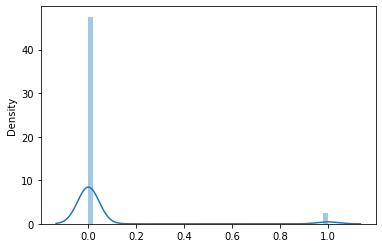

In [7]:
sample_df = df.select(['stroke']).sample(False, 0.5, 42)
pandas_df = sample_df.toPandas()
sns.distplot(pandas_df)

In [8]:
#influence of work type on getting stroke
#more private
df_work_type_stroke = df.groupBy('work_type', 'stroke').count().select('stroke','work_type',f.col('count').alias('work_type_count')).withColumn('percentage_of_work_type',(f.col('work_type_count') / df.count()) * 100 ).filter(df['stroke'] == 1).select('work_type',(format_number('percentage_of_work_type',2).alias('percentage_of_work_type'))).orderBy('work_type_count')


df_work_type_stroke.show()

+-------------+-----------------------+
|    work_type|percentage_of_work_type|
+-------------+-----------------------+
|     children|                   0.04|
|     Govt_job|                   0.65|
|Self-employed|                   1.27|
|      Private|                   2.92|
+-------------+-----------------------+



In [9]:
#influence of work type on getting stroke and gender
#more women in general and women in private
df_work_stroke_gender = df.groupBy('gender','work_type','stroke').count().select('gender','stroke','work_type',f.col('count').alias('work_type_count')).withColumn('percentage_of_work_type',(f.col('work_type_count') / df.count()) * 100 ).filter(df['stroke'] == 1).select('gender','work_type',(format_number('percentage_of_work_type',2).alias('percentage_of_work_type'))).orderBy('work_type')


df_work_stroke_gender.show()

+------+-------------+-----------------------+
|gender|    work_type|percentage_of_work_type|
+------+-------------+-----------------------+
|Female|     Govt_job|                   0.45|
|  Male|     Govt_job|                   0.20|
|  Male|      Private|                   1.43|
|Female|      Private|                   1.49|
|Female|Self-employed|                   0.78|
|  Male|Self-employed|                   0.49|
|Female|     children|                   0.04|
+------+-------------+-----------------------+



In [10]:
#influence of work type on getting stroke over 50  *******************************************
#more private

df_work_age = df.select('age','work_type','stroke').filter((df['stroke'] == 1) & (df['age'] > '50')).groupBy('work_type').count().withColumn('percentage_of_work_over50',(f.col('count') / df.count()) * 100 ).select('work_type',(format_number('percentage_of_work_over50',2).alias('percentage_of_work_over50'))) 

df_work_age.show()

+-------------+-------------------------+
|    work_type|percentage_of_work_over50|
+-------------+-------------------------+
|Self-employed|                     1.19|
|      Private|                     2.60|
|     Govt_job|                     0.63|
+-------------+-------------------------+



In [11]:
#participated in this clinic measurement
#58% Female. 41% Male
df_mes = df.groupBy('gender').count().select('gender',f.col('count').alias('count_gender')).withColumn('percentage_of_gender',(f.col('count_gender') / df.count()) * 100 ).select('gender','count_gender',(format_number('percentage_of_gender',2).alias('percentage_of_gender'))).orderBy('count_gender')

df_mes.show()

+------+------------+--------------------+
|gender|count_gender|percentage_of_gender|
+------+------------+--------------------+
| Other|           1|                0.02|
|  Male|        2115|               41.39|
|Female|        2994|               58.59|
+------+------------+--------------------+



In [12]:
# how many female/male have a stroke
# 2,11% Male. 2,76% Female
df_gen_str_M = df.groupBy('gender', 'stroke').count().select('gender',f.col('count').alias('count_gender')).withColumn('percentage_of_stroke',(f.col('count_gender') / df.count()) * 100 ).filter((df['stroke'] == 1) & (df['gender'] == 'Male')).select('gender','count_gender',(format_number('percentage_of_stroke',2).alias('percentage_of_stroke')))

df_gen_str_M.show()

df_gen_str_F = df.groupBy('gender', 'stroke').count().select('gender',f.col('count').alias('count_gender')).withColumn('percentage_of_stroke',(f.col('count_gender') / df.count()) * 100 ).filter((df['stroke'] == 1) & (df['gender'] == 'Female')).select('gender','count_gender',(format_number('percentage_of_stroke',2).alias('percentage_of_stroke')))

df_gen_str_F.show()

+------+------------+--------------------+
|gender|count_gender|percentage_of_stroke|
+------+------------+--------------------+
|  Male|         108|                2.11|
+------+------------+--------------------+

+------+------------+--------------------+
|gender|count_gender|percentage_of_stroke|
+------+------------+--------------------+
|Female|         141|                2.76|
+------+------------+--------------------+



In [13]:
#people have heart disease and stroke
df_stroke_heartdisease = df.groupBy('gender', 'stroke', 'heart_disease').count().select('gender',f.col('count').alias('count_gender')).withColumn('percentage_of_stroke',(f.col('count_gender') / df.count()) * 100 ).filter((df['stroke'] == 1) & (df['heart_disease'] == '1')).select('gender','count_gender',(format_number('percentage_of_stroke',2).alias('percentage_of_stroke'))).orderBy('count_gender')

df_stroke_heartdisease.show()

+------+------------+--------------------+
|gender|count_gender|percentage_of_stroke|
+------+------------+--------------------+
|Female|          19|                0.37|
|  Male|          28|                0.55|
+------+------------+--------------------+



In [14]:
#people have hypertension and stroke
df_stroke_hypertension = df.groupBy('gender', 'stroke', 'hypertension').count().select('gender',f.col('count').alias('count_gender')).withColumn('percentage_of_stroke',(f.col('count_gender') / df.count()) * 100 ).filter((df['stroke'] == 1) & (df['hypertension'] == '1')).select('gender','count_gender',(format_number('percentage_of_stroke',2).alias('percentage_of_stroke'))).orderBy('count_gender')

df_stroke_hypertension.show()

+------+------------+--------------------+
|gender|count_gender|percentage_of_stroke|
+------+------------+--------------------+
|  Male|          27|                0.53|
|Female|          39|                0.76|
+------+------------+--------------------+



In [15]:
#people have heart disease and hypertension and stroke
df_stroke_heartd_hyperd = df.groupBy('gender', 'stroke', 'heart_disease','hypertension').count().select('gender',f.col('count').alias('count_gender')).withColumn('percentage_of_stroke',(f.col('count_gender') / df.count()) * 100 ).filter((df['stroke'] == 1) & (df['heart_disease'] == '1') & (df['hypertension'] == '1')).select('gender','count_gender',(format_number('percentage_of_stroke',2).alias('percentage_of_stroke')))

df_stroke_heartd_hyperd.show()

+------+------------+--------------------+
|gender|count_gender|percentage_of_stroke|
+------+------------+--------------------+
|Female|           7|                0.14|
|  Male|           6|                0.12|
+------+------------+--------------------+



In [16]:
#influence of smoking_status on getting stroke
df_stroke_smoking= df.groupBy('smoking_status', 'stroke').count().select('smoking_status',f.col('count').alias('count_smoking_status')).withColumn('percentage_of_stroke',(f.col('count_smoking_status') / df.count()) * 100 ).filter((df['stroke'] == 1)).select('smoking_status','count_smoking_status',(format_number('percentage_of_stroke',2).alias('percentage_of_stroke'))).orderBy('count_smoking_status')

df_stroke_smoking.show()

+---------------+--------------------+--------------------+
| smoking_status|count_smoking_status|percentage_of_stroke|
+---------------+--------------------+--------------------+
|         smokes|                  42|                0.82|
|        Unknown|                  47|                0.92|
|formerly smoked|                  70|                1.37|
|   never smoked|                  90|                1.76|
+---------------+--------------------+--------------------+



In [17]:
#influence of smoking_status  and gender
df_stroke_smoking_Female= df.groupBy('smoking_status', 'stroke', 'gender').count().select('gender','smoking_status',f.col('count').alias('count_smoking_status')).withColumn('percentage_of_stroke',(f.col('count_smoking_status') / df.count()) * 100 ).filter((df['stroke'] == 1) & (df['gender'] == 'Female')).select('smoking_status','count_smoking_status',(format_number('percentage_of_stroke',2).alias('percentage_of_stroke_Female'))).orderBy('count_smoking_status')

df_stroke_smoking_Female.show()

+---------------+--------------------+---------------------------+
| smoking_status|count_smoking_status|percentage_of_stroke_Female|
+---------------+--------------------+---------------------------+
|         smokes|                  19|                       0.37|
|        Unknown|                  25|                       0.49|
|formerly smoked|                  34|                       0.67|
|   never smoked|                  63|                       1.23|
+---------------+--------------------+---------------------------+



In [18]:
#influence of smoking_status on getting stroke
df_stroke_smoking_Male= df.groupBy('smoking_status', 'stroke', 'gender').count().select('gender','smoking_status',f.col('count').alias('count_smoking_status')).withColumn('percentage_of_stroke',(f.col('count_smoking_status') / df.count()) * 100 ).filter((df['stroke'] == 1) & (df['gender'] == 'Male')).select('smoking_status','count_smoking_status',(format_number('percentage_of_stroke',2).alias('percentage_of_stroke_Male'))).orderBy('count_smoking_status')
df_stroke_smoking_Male.show()

+---------------+--------------------+-------------------------+
| smoking_status|count_smoking_status|percentage_of_stroke_Male|
+---------------+--------------------+-------------------------+
|        Unknown|                  22|                     0.43|
|         smokes|                  23|                     0.45|
|   never smoked|                  27|                     0.53|
|formerly smoked|                  36|                     0.70|
+---------------+--------------------+-------------------------+



In [19]:
#influence of Residence_type on getting stroke 
df_stroke_restype= df.groupBy('Residence_type', 'stroke').count().select('Residence_type',f.col('count').alias('count_Residence_type')).withColumn('percentage_of_stroke',(f.col('count_Residence_type') / df.count()) * 100 ).filter((df['stroke'] == 1)).select('Residence_type','count_Residence_type',(format_number('percentage_of_stroke',2).alias('percentage_of_stroke'))).orderBy('count_Residence_type')

df_stroke_restype.show()

+--------------+--------------------+--------------------+
|Residence_type|count_Residence_type|percentage_of_stroke|
+--------------+--------------------+--------------------+
|         Rural|                 114|                2.23|
|         Urban|                 135|                2.64|
+--------------+--------------------+--------------------+



In [20]:
#influence of ever_married on getting stroke
#if married more influence on getting stroke
df_stroke_ever_married= df.groupBy('ever_married', 'stroke').count().select('ever_married',f.col('count').alias('count_ever_married')).withColumn('percentage_of_stroke',(f.col('count_ever_married') / df.count()) * 100 ).filter((df['stroke'] == 1)).select('ever_married','count_ever_married',(format_number('percentage_of_stroke',2).alias('percentage_of_stroke'))).orderBy('count_ever_married')

df_stroke_ever_married.show()

+------------+------------------+--------------------+
|ever_married|count_ever_married|percentage_of_stroke|
+------------+------------------+--------------------+
|          No|                29|                0.57|
|         Yes|               220|                4.31|
+------------+------------------+--------------------+



In [21]:
#influence of ever_married on getting stroke by gender (general Female are at risk to have a stoke)
df_stroke_ever_married= df.groupBy('gender','ever_married', 'stroke').count().select('gender','ever_married',f.col('count').alias('count_ever_married')).withColumn('percentage_of_stroke',(f.col('count_ever_married') / df.count()) * 100 ).filter((df['stroke'] == 1)).select('gender','ever_married','count_ever_married',(format_number('percentage_of_stroke',2).alias('percentage_of_stroke'))).orderBy('count_ever_married')

df_stroke_ever_married.show()


+------+------------+------------------+--------------------+
|gender|ever_married|count_ever_married|percentage_of_stroke|
+------+------------+------------------+--------------------+
|  Male|          No|                 8|                0.16|
|Female|          No|                21|                0.41|
|  Male|         Yes|               100|                1.96|
|Female|         Yes|               120|                2.35|
+------+------------+------------------+--------------------+



In [22]:
#people have hypertension and stroke and over 50 or dont have hypertension
df_hyp_age = df.select('age','hypertension','stroke').filter((df['stroke'] == 1) & (df['age'] > '50')).groupBy('hypertension').count().withColumn('percentage_of_hyp_over50',(f.col('count') / df.count()) * 100 ).select('hypertension',(format_number('percentage_of_hyp_over50',2).alias('percentage_of_hyp_over50'))) 

df_hyp_age.show()




+------------+------------------------+
|hypertension|percentage_of_hyp_over50|
+------------+------------------------+
|           1|                    1.23|
|           0|                    3.19|
+------------+------------------------+



In [23]:
#people have heart_disease and stroke and over 50 or dont have heart_disease
df_heart_age = df.select('age','heart_disease','stroke').filter((df['stroke'] == 1) & (df['age'] > '50')).groupBy('heart_disease').count().withColumn('percentage_of_heart_over50',(f.col('count') / df.count()) * 100 ).select('heart_disease',(format_number('percentage_of_heart_over50',2).alias('percentage_of_heart_over50'))) 

df_heart_age.show()

+-------------+--------------------------+
|heart_disease|percentage_of_heart_over50|
+-------------+--------------------------+
|            1|                      0.92|
|            0|                      3.50|
+-------------+--------------------------+



In [24]:
#people have a troke over 50
df.filter((df['stroke'] == 1) & (df['age'] > '50')).count()


226

In [25]:
#percentage person over 50 that have stroke
#4.4 %
df_age_per = ((df.filter((df['stroke'] == 1) & (df['age'] > '50')).count() ) / df.count() ) * 100 
df_age_per

4.422700587084149

In [26]:
#people have a stroke
df.filter((df['stroke'] == 1)).count()

249

In [27]:
#percentage person that have stroke
#0.39 %
df_age_per1 = ((df.filter((df['stroke'] == 1)).count() ) / df.count() ) * 100 
df_age_per1

4.87279843444227

In [30]:

df_avg = df.groupBy("stroke").agg(F.mean('bmi'), F.mean('age'), F.mean('avg_glucose_level'))
df_avg.show()

NameError: name 'F' is not defined

In [34]:
#remove columns with missing values


from pyspark.sql.functions import col
myDF = df.select([F.count(F.when(F.isnan(i) | \
                                   F.col(i).contains('N/A') | \
                                   F.col(i).contains('Unknown') | \
                                   F.col(i).isNull(), i)).alias(i) \
                    for i in df.columns])


myDF.show()

+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
| id|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi|smoking_status|stroke|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|  0|     0|  0|           0|            0|           0|        0|             0|                0|201|          1544|     0|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+



In [40]:
df_remCol = df.drop("bmi","smoking_status")
df_remCol.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- stroke: integer (nullable = true)



In [41]:
#complete missing values with avg of the column 

#the average of the column
df.agg({'bmi': 'avg'}).collect()[0]


Row(avg(bmi)=28.893236911794673)

In [43]:
# the completed data with column smoking status
df_replace = df.na.replace(['N/A'],['28.89'])
#the data without column smoking status 
df_replace = df_replace.drop("smoking_status")
df_replace.show()

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+-----+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level|  bmi|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+-----+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69| 36.6|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21|28.89|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92| 32.5|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23| 34.4|     1|
| 1665|Female|79.0|           1|            0|         Yes|Self-employed|         Rural|           174.12|   24|     1|
|56669|  Male|81.0|           0|        